<a href="https://colab.research.google.com/github/allensheneka/systemRx/blob/main/systemRx_part3r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##systemRx

Project 2

Author:  Sheneka Allen

##Part I - Load, Clean, and Prepare data for ML

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

#import some necessary tools
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.metrics import roc_auc_score, ConfusionMatrixDisplay

#import classification report
from sklearn.metrics import classification_report

#Importing the Classifiers
from xgboost import XGBClassifier

#unsupervised learning tools, metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [82]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [83]:
# upload Predictive Maintenance data file 

filename = ('/content/drive/MyDrive/000 Data Science/ai4i2020.csv')
pDm_df = pd.read_csv(filename)
pDm_df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [84]:
# correct or rename column

# Modified code: https://www.statology.org/pandas-rename-columns/
pDm_df.rename(columns = {'UDI':'UID'}, inplace = True)
pDm_df.head()

,UID,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [85]:
pDm_df.duplicated().sum()

0

In [86]:
pDm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UID                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

In [87]:
# Check for inconsistencies
pDm_df['Type'].value_counts()

L    6000
M    2997
H    1003
Name: Type, dtype: int64

###Type values are good.

#Explore machine failures in dataset

In [88]:
# Modified code to check dataframe for a specific value: 
# https://thispointer.com/pandas-check-if-a-value-exists-in-a-dataframe-using-in-not-in-operator-isin/

pDm_df.isin([1]).any()

UID                         True
Product ID                 False
Type                       False
Air temperature [K]        False
Process temperature [K]    False
Rotational speed [rpm]     False
Torque [Nm]                False
Tool wear [min]            False
Machine failure             True
TWF                         True
HDF                         True
PWF                         True
OSF                         True
RNF                         True
dtype: bool

###UID is just a unique identifier for the product, so '1' in its column does not indicate machine failure.

###Machine failure, TWD, HDF, PWF, OSF, RNF all returned boolean 'True' for '1' value or failure in their columns.

In [89]:
#determine total number of Machine failures in dataset
pDm_df['Machine failure'].value_counts()

0    9661
1     339
Name: Machine failure, dtype: int64

###There is a total of 339 Machine failures in this dataset

In [90]:
#tool wear failure row count resulting in machine failure
pDm_df.groupby(['Machine failure', 'TWF']).count()

UID  Product ID  Type  Air temperature [K]  \
Machine failure TWF                                                
0               0    9661        9661  9661                 9661   
1               0     293         293   293                  293   
                1      46          46    46                   46   

                     Process temperature [K]  Rotational speed [rpm]  \
Machine failure TWF                                                    
0               0                       9661                    9661   
1               0                        293                     293   
                1                         46                      46   

                     Torque [Nm]  Tool wear [min]   HDF   PWF   OSF   RNF  
Machine failure TWF                                                        
0               0           9661             9661  9661  9661  9661  9661  
1               0            293              293   293   293   293   293  
                1             46               46    46    46    46    46

###Tool wear failures are 13.56% causal of Machine failures.

In [91]:
#heat dissipation failure row count resulting in machine failure
pDm_df.groupby(['Machine failure', 'HDF']).count()

UID  Product ID  Type  Air temperature [K]  \
Machine failure HDF                                                
0               0    9661        9661  9661                 9661   
1               0     224         224   224                  224   
                1     115         115   115                  115   

                     Process temperature [K]  Rotational speed [rpm]  \
Machine failure HDF                                                    
0               0                       9661                    9661   
1               0                        224                     224   
                1                        115                     115   

                     Torque [Nm]  Tool wear [min]   TWF   PWF   OSF   RNF  
Machine failure HDF                                                        
0               0           9661             9661  9661  9661  9661  9661  
1               0            224              224   224   224   224   224  
                1            115              115   115   115   115   115

###Heat dissipation failure is the #1 independent failure type resulting in Machine failures, roughly 33.9% causal.

In [92]:
#power failure row count resulting in machine failure
pDm_df.groupby(['Machine failure', 'PWF']).count()

UID  Product ID  Type  Air temperature [K]  \
Machine failure PWF                                                
0               0    9661        9661  9661                 9661   
1               0     244         244   244                  244   
                1      95          95    95                   95   

                     Process temperature [K]  Rotational speed [rpm]  \
Machine failure PWF                                                    
0               0                       9661                    9661   
1               0                        244                     244   
                1                         95                      95   

                     Torque [Nm]  Tool wear [min]   TWF   HDF   OSF   RNF  
Machine failure PWF                                                        
0               0           9661             9661  9661  9661  9661  9661  
1               0            244              244   244   244   244   244  
                1             95               95    95    95    95    95

###Power failure is the #3 independent failure type resulting in Machine failure, roughly 28.02% causal

In [93]:
#overstrain failure row count resulting in machine failure
pDm_df.groupby(['Machine failure', 'OSF']).count()

UID  Product ID  Type  Air temperature [K]  \
Machine failure OSF                                                
0               0    9661        9661  9661                 9661   
1               0     241         241   241                  241   
                1      98          98    98                   98   

                     Process temperature [K]  Rotational speed [rpm]  \
Machine failure OSF                                                    
0               0                       9661                    9661   
1               0                        241                     241   
                1                         98                      98   

                     Torque [Nm]  Tool wear [min]   TWF   HDF   PWF   RNF  
Machine failure OSF                                                        
0               0           9661             9661  9661  9661  9661  9661  
1               0            241              241   241   241   241   241  
                1             98               98    98    98    98    98

###Overstrain failure is the #2 independent failure type resulting in Machine failures, roughly 28.91% causal.

In [94]:
#random failure resulting in machine failure
pDm_df.groupby(['Machine failure', 'RNF']).count()

UID  Product ID  Type  Air temperature [K]  \
Machine failure RNF                                                
0               0    9643        9643  9643                 9643   
                1      18          18    18                   18   
1               0     338         338   338                  338   
                1       1           1     1                    1   

                     Process temperature [K]  Rotational speed [rpm]  \
Machine failure RNF                                                    
0               0                       9643                    9643   
                1                         18                      18   
1               0                        338                     338   
                1                          1                       1   

                     Torque [Nm]  Tool wear [min]   TWF   HDF   PWF   OSF  
Machine failure RNF                                                        
0               0           9643             9643  9643  9643  9643  9643  
                1             18               18    18    18    18    18  
1               0            338              338   338   338   338   338  
                1              1                1     1     1     1     1

###Random failures are .294% causal of Machine failures.

###Oddly, 18 random failures did NOT result in a Machine failures.

#Visualizations - Exploratory Data Analysis
##Part II

In [95]:
# use pandas.melt to reshape the dataframe and visualize causal relationship 
# between independent failures and machine failure

# Modified code: https://stackoverflow.com/questions/38807895/seaborn-multiple-barplots,
# https://pandas.pydata.org/docs/reference/api/pandas.melt.html

new_pDm_df = pd.melt(pDm_df, id_vars=['Machine failure'], value_vars=['TWF', 'HDF', 'PWF', 'OSF', 'RNF'], 
                     var_name='Type failure', value_name='Type failure value')

new_pDm_df.head()



,Machine failure,Type failure,Type failure value
0,0,TWF,0
1,0,TWF,0
2,0,TWF,0
3,0,TWF,0
4,0,TWF,0


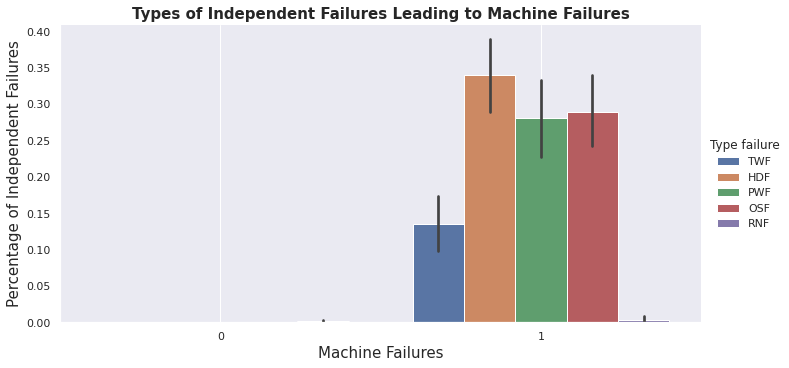

In [101]:
# create a barplot explaining causes for machine failures
sns.catplot(x='Machine failure', y='Type failure value', hue='Type failure', data=new_pDm_df, kind='bar', height=5, aspect=2)
plt.grid()
plt.title('Types of Independent Failures Leading to Machine Failures', fontweight='bold', fontsize=15)
plt.xlabel('Machine Failures', fontsize=15)
plt.ylabel('Percentage of Independent Failures', fontsize=15);

###This barplot shows Type independent failure totals (by percent) and clearly graphs the TOP 3 categories:


1.   HDF which precede ~33% of machine failures (1)
2.   OSF which precede ~28% of machine failures
3.   PWF which precede ~26% of machine failures

###A very small percentage of Random Failures - RNF - (about .001%) occurred but they did not cause a Machine Failure (0 = no machine failure).

###Although the machine model does not distinguish between which indepedent failure triggers a machine failure, I decided to keep their columns to investigate which indepedent failure occur most frequently in this dataset.  This could provide insight into common precursors to full machine failure.

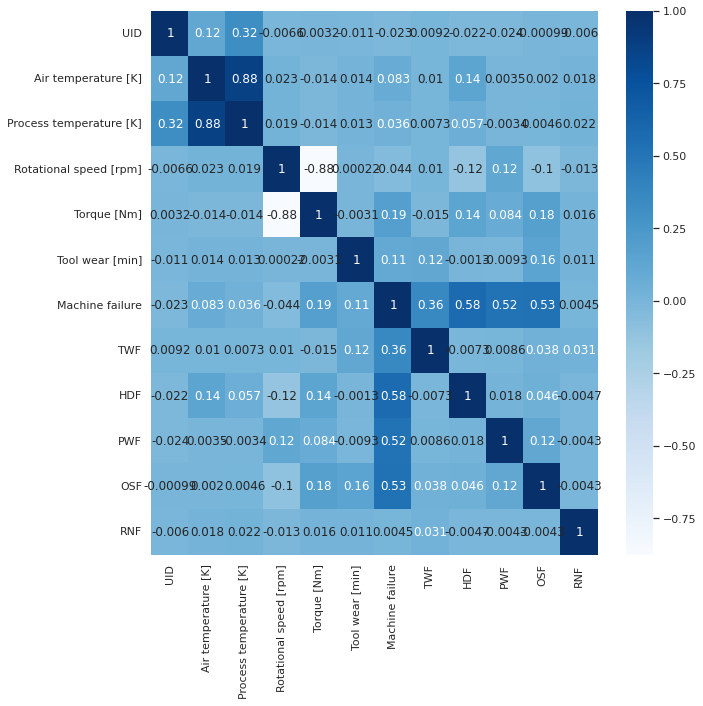

In [97]:
#create a heatmap variable
corr = pDm_df.corr()

# add correlation coefficients to heatmap with annot = True
plt.subplots(figsize=(10,10))
sns.heatmap(corr, cmap = 'Blues', annot = True);

###This heatmap further confirms that HDF, OSF and PWF independent failures (scores .58, .53, .52, respectively) are strongly correlated with Machine Failure

###Rotational Temperature and Air Temperature have a strong postive correlation with .88 scores

###Rotational Speed and Torque have a strong negative correlation with a -.88 score

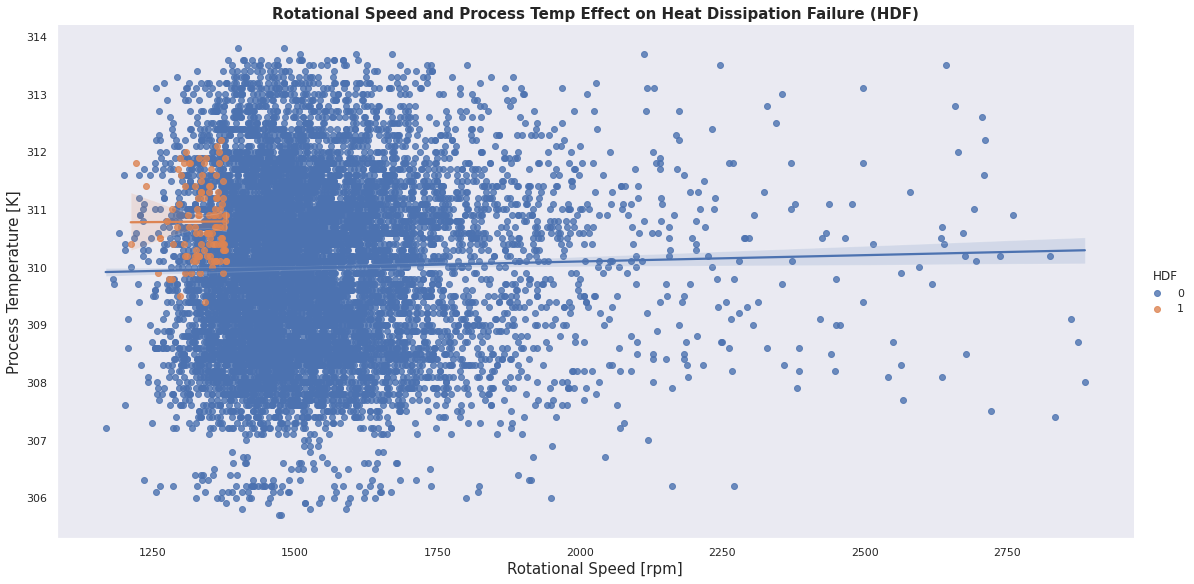

In [102]:
# explore multiple linear regression plot for Process temperature and Rotational speed effect on HDF

sns.lmplot(data=pDm_df, x='Rotational speed [rpm]', y='Process temperature [K]', hue='HDF', height=8, aspect=2)
plt.grid()
plt.title('Rotational Speed and Process Temp Effect on Heat Dissipation Failure (HDF)', fontweight='bold', fontsize=15)
plt.xlabel('Rotational Speed [rpm]', fontsize=15)
plt.ylabel('Process Temperature [K]', fontsize=15);

###This unique scatterplot allows me to explore interactions with categorical variables and it seems to show that the HDF type failure occurs most when between 1250-1375 rpm Rotational Speed and 309.5 - 312 kelvin Process Temperature.

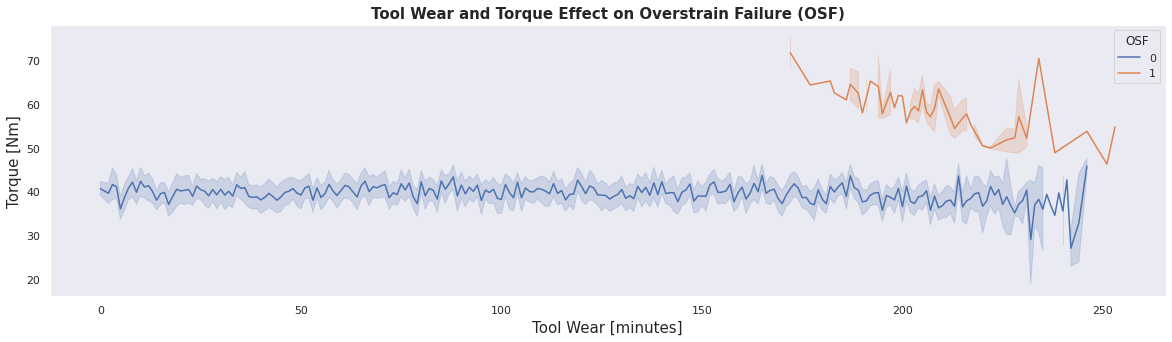

In [99]:
# explore Tool wear and torque on OSF 
plt.subplots(figsize=(20,5))
sns.lineplot(data=pDm_df, x='Tool wear [min]', y='Torque [Nm]', hue='OSF')
plt.title('Tool Wear and Torque Effect on Overstrain Failure (OSF)', fontweight='bold', fontsize=15)
plt.grid()
plt.xlabel('Tool Wear [minutes]', fontsize=15)
plt.ylabel('Torque [Nm]', fontsize=15);

###Based on this lineplot, Overstrain Failures (Tool Wear x Torque) occur most frequently between 11,550 - 12,000 min-Nm or between 165 - 250 Tool Wear min and 48 - 70 Torque Nm.

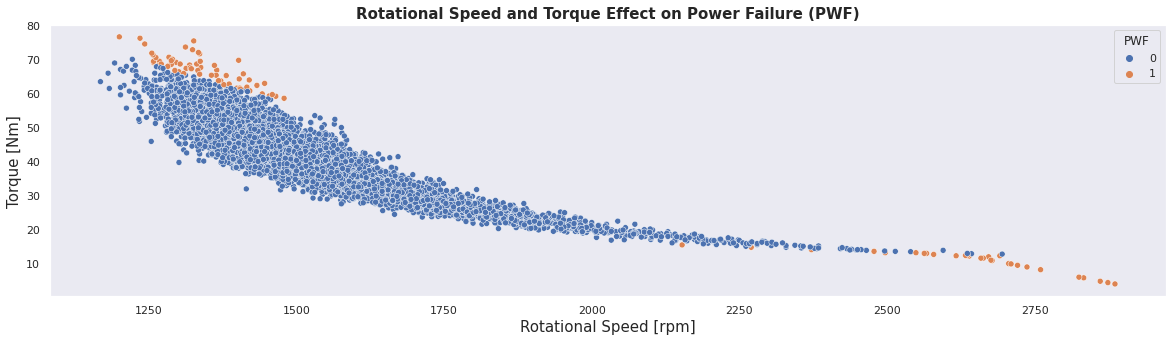

In [103]:
# explore Rotational speed and torque effect on PWF
plt.subplots(figsize=(20,5))
sns.scatterplot(data=pDm_df, x='Rotational speed [rpm]', y='Torque [Nm]', hue='PWF')
plt.title('Rotational Speed and Torque Effect on Power Failure (PWF)', fontweight='bold', fontsize=15)
plt.grid()
plt.xlabel('Rotational Speed [rpm]', fontsize=15)
plt.ylabel('Torque [Nm]', fontsize=15);

###Interestingly, this chart shows PWF (Torque x Speed (in radians/sec)) and ultimately Machine Failure occurs most in two instances: 

1.  Low Rotational Speed and High Torque (1250-1500 rpm and 60-75 Nm) OR PWF above ~7853 Watts

2.  High Rotational Speed and Low Torque (2500-2875 rpm and 3-12 Nm) OR PWF below ~3612 Watts



#Prepare data for Machine Learning

In [104]:
pDm_df['Type'].replace({'L': 0, 'M': 1, 'H': 2}, inplace=True)
pDm_df['Type'].value_counts()

0    6000
1    2997
2    1003
Name: Type, dtype: int64

In [105]:
# Align all datatypes with data dictionary
pDm_df['Type'] = pDm_df['Type'].astype(object)

In [106]:
# Determine target(y) and features(X) vectors
X = pDm_df.drop(columns=['Product ID', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'Machine failure'])
y = pDm_df['Machine failure']

X.head()

,UID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
0,1,1,298.1,308.6,1551,42.8,0
1,2,0,298.2,308.7,1408,46.3,3
2,3,0,298.1,308.5,1498,49.4,5
3,4,0,298.2,308.6,1433,39.5,7
4,5,0,298.2,308.7,1408,40.0,9


In [107]:
#Split the data into training and validation sets

#Since such a hugh imbalance between common and minority class, allocated 35% of data to test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#Class Balance

In [108]:
#Check the balance of classes
pDm_df['Machine failure'].value_counts()

0    9661
1     339
Name: Machine failure, dtype: int64

In [109]:
print(y.value_counts(normalize=True))

0    0.9661
1    0.0339
Name: Machine failure, dtype: float64


##So, just 3.39% of model predictions are actual machine failures ('positive' class).  Based on this dataset, these systems rarely have machine failures and are essentially in good 'health'.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


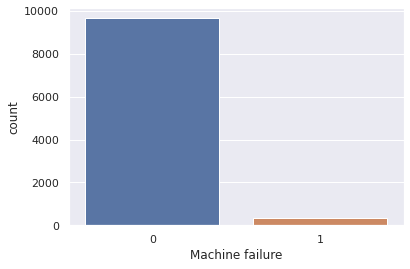

In [110]:
# visualize the target variable
sns.countplot(pDm_df['Machine failure']);

###Huge data imbalance!  Model predictions will be almost 97% accurate since the most common class (NON-machine failures, 0) is so large, not necessarily because the model is good.  Will need to explore the model's training and test prediction performance using classification metrics.

##Select data for preprocessing, create pipeline, fit training data to model

In [111]:
cat_select = make_column_selector(dtype_include='object')
num_select = make_column_selector(dtype_include='number')

# add (scaler, selector) to preprocessor
preprocess = ColumnTransformer(transformers=[('scaler', MinMaxScaler(), num_select),
                                             ('ohe', OneHotEncoder(handle_unknown='ignore'), cat_select)],
                               remainder = 'drop')

In [112]:
# create pipeline with preprocessor and XGB model
xgb_pipe = Pipeline(steps=[('preprocessor', preprocess), 
                           ('model', XGBClassifier())])

In [113]:
# fit model to data
xgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f3598d6a250>),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f3598d6ac10>)])),
                ('model', XGBClassifier())])

In [114]:
# predict values for the training and test set
train_preds = xgb_pipe.predict(X_train)
test_preds = xgb_pipe.predict(X_test)

##Part III - Deeper EDA and Identify Key Findings of Value for Stakeholders

1.  For this part of the project, I am contining EDA by 
Identifying any moderate or strong correlations between the target and features and/or between one feature and another.  I have created multivariate exploratory visuals to further understand the data.

2.  I have also created multiple visuals that demonstrate key findings of interest to an engineer, maintenance supervisor or senior manager. This visual(s) reports quality and include a short data analysis summary.

##Visualize Classifier Model Performance

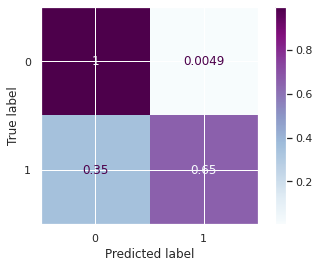

In [166]:
ConfusionMatrixDisplay.from_predictions(y_test, test_preds, cmap='BuPu', normalize='true');

In [117]:
#Use classification_report() to print a report of several metrics for all classes at once
#for the model

test_report_xgb = classification_report(y_test, test_preds)
print('Classification Reporting for Test Set (XGB):')
print(test_report_xgb)

Classification Reporting for Test Set (XGB):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2428
           1       0.80      0.65      0.72        72

    accuracy                           0.99      2500
   macro avg       0.89      0.82      0.85      2500
weighted avg       0.98      0.99      0.98      2500



The XGBClassifier model performed decently as evidenced by its classification report heatmap below which indicates 80% precision and an average of 65% recall.  Translation: basically 0 (.049%) false positives and 35% false negatives for this model. Accuracy is 99%, very high and expected, since the data is unbalanced and in favor of 'NO Machine Failures'.

In [118]:
#Explore additional correlations between target (Machine failures) and selected features (X)
pDm_df2 = pd.melt(pDm_df, id_vars=['Machine failure'], value_vars=['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]'], 
                     var_name='features', value_name='value')

pDm_df2.head()

,Machine failure,features,value
0,0,Air temperature [K],298.1
1,0,Air temperature [K],298.2
2,0,Air temperature [K],298.1
3,0,Air temperature [K],298.2
4,0,Air temperature [K],298.2


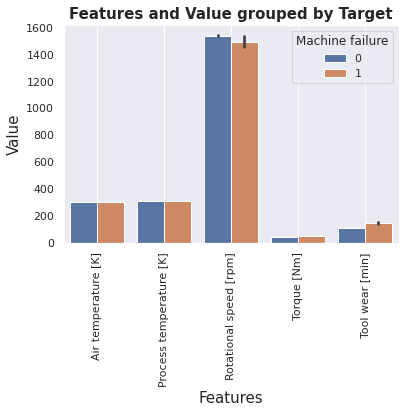

In [119]:
sns.barplot(data=pDm_df2, x='features', y='value', hue='Machine failure')
plt.title('Features and Value grouped by Target', fontweight='bold', fontsize=15)
plt.grid()
plt.xlabel('Features', fontsize=15)
plt.ylabel('Value', fontsize=15);
plt.xticks(rotation=90);

These appear to be good features to explore in this dataset based on the barplot.

The most machine failures are tied to Rotational speed and Temperature (Air and Process)

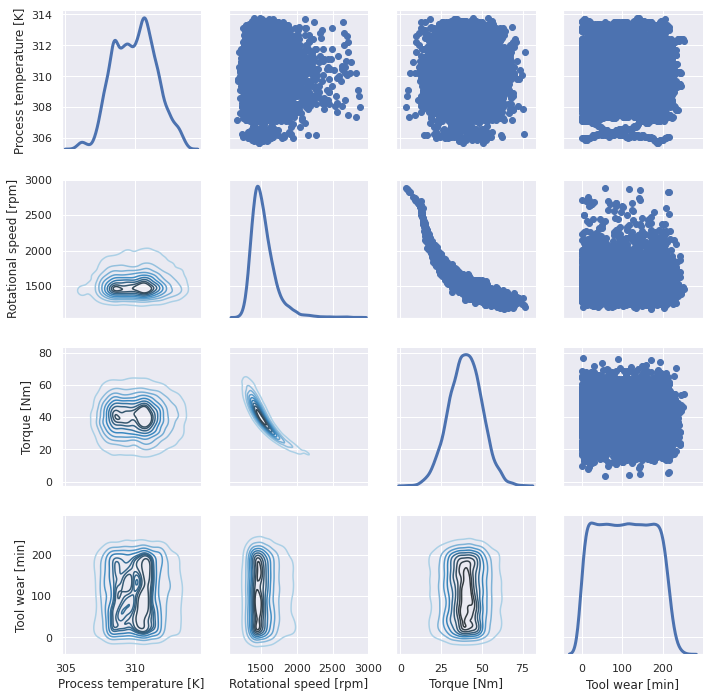

In [120]:
#Explore correlations between features
#Modified code: https://www.kaggle.com/code/kanncaa1/feature-selection-and-data-visualization/notebook
sns.set(style="darkgrid")
features_df = pDm_df.loc[:,['Process temperature [K]','Rotational speed [rpm]','Torque [Nm]', 'Tool wear [min]']]
g = sns.PairGrid(features_df, diag_sharey=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3)

##Summary of feature correlations in Pair Grid Plot

###These visualizations take some time to interpret, but I concluded the following:

1) **Rotational speed and Torque** - strong negative correlation (increase speed will decrease torque); downward trending and very similiar-looking scatterplot and kdeplot (kernel density estimation) that depicts the numeric distribution of these features

2) **Rotational speed and Tool wear** - Tool wear in the 0-100 min and 122-200 min ranges appear to correlate most with Rotational speed in the 1500 rpm range

3) **Torque and Process temperature** - Torque in the 30-50 Nm range appears to correlate most with Process temperature in 308-312 K range

4) **Torque and Tool wear** - Torque in the 37-50 Nm range appears to correlate most with Tool wear in the 0-200 min range

In [121]:
#drop unnecessary columns/features from dataset
km_df = pDm_df.drop(columns=['UID', 'Product ID', 'Type', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'])

In [122]:
km_df.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
0,298.1,308.6,1551,42.8,0,0
1,298.2,308.7,1408,46.3,3,0
2,298.1,308.5,1498,49.4,5,0
3,298.2,308.6,1433,39.5,7,0
4,298.2,308.7,1408,40.0,9,0


In [123]:
#Establish clusters based on Air temperature [K], Process temperature [K], Rotational speed [rpm], Torque [Nm] and Tool wear [min]
#Determine optimal clusters
#Make a scatterplot and color code based on clusters

# Instantiate Standard Scaler to normalize dataset values for ML
scaler = StandardScaler()
# Fit & transform data.
scaled_km_df = scaler.fit_transform(km_df)

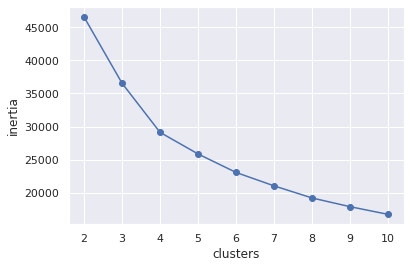

In [124]:
#Create an empty list of inertias
inertias = []
#Loop through k values between 2 and 11 and store the inertias in the list.
for k in range(2,11):  
  kmeans = KMeans(n_clusters=k)  
  kmeans.fit(scaled_km_df)  
  inertias.append(kmeans.inertia_)

#Visualize scores
plt.plot(range(2,11), inertias, marker = 'o')
plt.xlabel('clusters')
plt.ylabel('inertia');

There is an elbow at 3 and 4, but I will choose 4 in this case since it appears to be the lowest point in the plot before starting to level out.

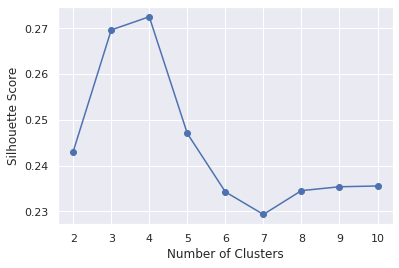

In [125]:
# Visualize different silhouette scores
# Save silhouette scores for various cluster numbers in list
silhouette_scores = []
for i in range(2, 11):
  kmeans = KMeans(n_clusters = i)
  kmeans.fit(scaled_km_df)
  silhouette_scores.append(silhouette_score(scaled_km_df, kmeans.labels_))

# Visualize scores
plt.plot(range(2, 11), silhouette_scores, marker = 'o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score');

The highest silhouette score is 4 based on this plot.

In [126]:
# I am going to fit 2 different KMeans models, one with 3 clusters and one with 4 clusters to see contrast
kmeans3 = KMeans(n_clusters = 3)
kmeans4 = KMeans(n_clusters = 4)
kmeans3.fit(scaled_km_df)
kmeans4.fit(scaled_km_df)

KMeans(n_clusters=4)

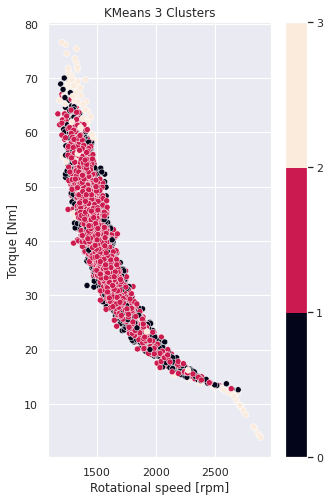

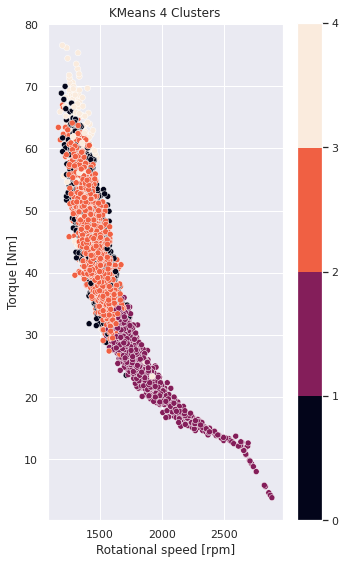

In [150]:
# Save the cluster labels to the dataframe 
km_df['cluster3'] = kmeans3.labels_
km_df['cluster4'] = kmeans4.labels_

# Visualize the clusters for Rotational speed and Torque
# Modified code: https://stackoverflow.com/questions/63060980/uniform-tick-labels-for-non-linear-colorbar-in-matplotlib

#First KMeans plot
print('\n')
plt.subplots(figsize=(5,8))
ax = sns.scatterplot(data=km_df, x='Rotational speed [rpm]', y='Torque [Nm]', c = km_df['cluster3'])

# normalize bound values
bounds = [0,1,2,3]
norm = mpl.colors.BoundaryNorm(bounds, ncolors=256)

sm = plt.cm.ScalarMappable(norm=norm)
ax.figure.colorbar(sm)
plt.xlabel('Rotational speed [rpm]')
plt.ylabel('Torque [Nm]')
plt.title('KMeans 3 Clusters')

# Second KMeans plot
plt.subplots(figsize=(5,8))
ax = sns.scatterplot(data=km_df, x='Rotational speed [rpm]', y='Torque [Nm]', c= km_df['cluster4'])

# normalize bound values
bounds = [0,1,2,3,4]
norm = mpl.colors.BoundaryNorm(bounds, ncolors=256)

sm = plt.cm.ScalarMappable(norm=norm)
ax.figure.colorbar(sm)
plt.xlabel('Rotational speed [rpm]')
plt.ylabel('Torque [Nm]')
plt.title('KMeans 4 Clusters')
plt.tight_layout()


##K-Means Analysis 1

###Referencing EDA I completed earlier on this project:

1) KMeans 3 Cluster - the TAN cluster is the data group that drives machine failures for Rotational speed [rpm] and Torque [Nm] ranges

2) KMeans 4 Cluster - the TAN and a small portion of the tail-end PURPLE cluster are the groups that drive machine failures for process temp and Torque ranges

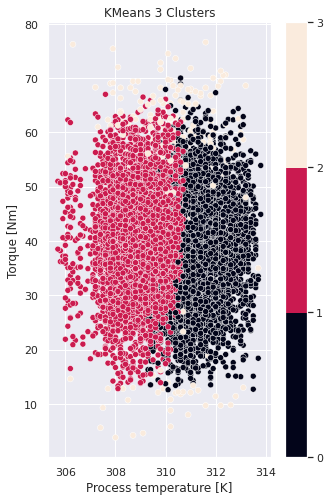

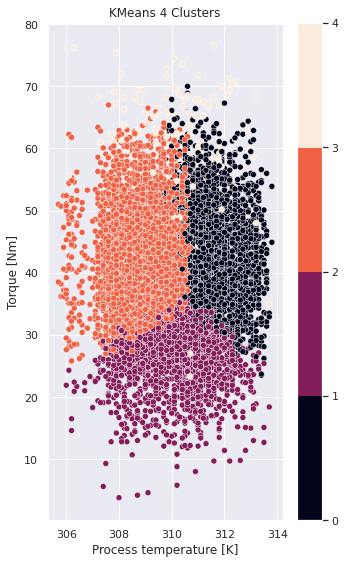

In [164]:
# Visualize the clusters for Process temperature and Torque

#First KMeans plot
print('\n')
plt.subplots(figsize=(5,8))
ax = sns.scatterplot(data=km_df, x='Process temperature [K]', y='Torque [Nm]', c = km_df['cluster3'])

# normalize bound values
bounds = [0,1,2,3]
norm = mpl.colors.BoundaryNorm(bounds, ncolors=256)

sm = plt.cm.ScalarMappable(norm=norm)
ax.figure.colorbar(sm)

plt.xlabel('Process temperature [K]')
plt.ylabel('Torque [Nm]')
plt.title('KMeans 3 Clusters')

#Second KMeans plot
plt.subplots(figsize=(5,8))
ax = sns.scatterplot(data=km_df, x='Process temperature [K]', y='Torque [Nm]', c= km_df['cluster4'])

# normalize bound values
bounds = [0,1,2,3,4]
norm = mpl.colors.BoundaryNorm(bounds, ncolors=256)

sm = plt.cm.ScalarMappable(norm=norm)
ax.figure.colorbar(sm)

plt.xlabel('Process temperature [K]')
plt.ylabel('Torque [Nm]')
plt.title('KMeans 4 Clusters')
plt.tight_layout()

##K-Means Analysis 2

###Cross-referencing EDA I completed earlier on this project:

1) KMeans 3 Cluster - the RED cluster is the data group that drives machine failures for process temp and Torque ranges

2) KMeans 4 Cluster - the ORANGE and a small portion of the PURPLE cluster are the groups that drive machine failures for process temp and Torque ranges